In [1]:
import astropy.units as u
from dustmaps.sfd import SFDWebQuery
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.table import Table
from astropy.io import ascii, fits
import logging
from galpy.util import bovy_coords
from progressbar import *
from astropy.io import ascii



In [4]:


%load_ext autoreload
import test

In [21]:

data_path = '/Users/iraf1/Downloads/gaia_sample.csv'

data = ascii.read(data_path)

In [22]:
test_data = data[0:55000] # reduce the size

In [23]:
import astropy.units as u
from dustmaps.sfd import SFDWebQuery
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.table import Table
from astropy.io import ascii, fits
from galpy.util import bovy_coords


class rgb():
    """
    Create RGB star selection object.
    
    """

    def __init__(self, data):
        self.data = data


    def dust_correction(self, r_ks=0.306, r_j=0.72, r_h=0.46):
        """
        For 2MASS bandpasses: ks, j and h magnitudes, this function will return the corrected magnitudes based of the
        SFD E(B-V) values at a given for a line of sight in Galactic coordinates (l,b).
        Exctinction coefficients r_ are bandpassses taken by Yuan et al. 2013.

        Input
        ------
        data(astropy.table): Astropy table contaning (contains: ks_mag, j_mag, h_mag)

        Output
        -------
        data(astropy.table): Initial data table in addition to new columns: (ks0, j0, h0, aks, aj, ah)

        """

        # Transform RA, DEC to l,b
        lb = bovy_coords.radec_to_lb(data['ra'], data['dec'], degree=True)
        l, b = lb[:, 0], lb[:, 1]

        N = len(l) # Total number of stars in data file
        query_max = 1000000 # maximum number of sources we can query
        N_int = N/query_max # Split the data to query

        L = np.arange(0, (int(N_int)+1)*query_max, step=query_max)
        L = np.append(L, N) # add last value of total N points

        sfd = SFDWebQuery() # call SFD query function

        ks0 = np.ndarray(shape=(N,1)) # empty array for corrected magnitudes
        j0 = np.ndarray(shape=(N,1)) # empty array for corrected magnitudes
        h0 = np.ndarray(shape=(N,1)) # empty array for corrected magnitudes
        aks = np.ndarray(shape=(N,1)) # empty array for corrected magnitudes
        aj = np.ndarray(shape=(N,1)) # empty array for corrected magnitudes
        ah = np.ndarray(shape=(N,1)) # empty array for corrected magnitudes

        for i in range (0, len(L)-1):

            # Select the Galactic coordinates we want to estimate E(B-V)
            l_ad = l[L[i]:L[i+1]]
            b_ad = b[L[i]:L[i+1]]
            coords = SkyCoord(l_ad*u.deg, b_ad*u.deg, frame='galactic')

            # Query coords and return E(B-V) SFD for each source
            ebv_sfd = sfd(coords)

            # Apply corrections to each magnitude band based on E(B-V) estimates
            corr_ks = ((data['ks_m'])[L[i]:L[i+1]]) - (r_ks*ebv_sfd)
            corr_j = ((data['j_m'])[L[i]:L[i+1]]) - (r_j*ebv_sfd)
            corr_h = ((data['h_m'])[L[i]:L[i+1]]) - (r_h*ebv_sfd)

            # corrected magnitudes
            ks0[L[i]:L[i+1], 0] = corr_ks
            j0[L[i]:L[i+1], 0] = corr_j
            h0[L[i]:L[i+1], 0] = corr_h
            # exctinction coefficient appends
            aks[L[i]:L[i+1], 0] = r_ks*ebv_sfd
            aj[L[i]:L[i+1], 0] = r_j*ebv_sfd
            ah[L[i]:L[i+1], 0] = r_h*ebv_sfd


        dat = Table([ks0, j0, h0, aks, aj, ah], names=('ks0', 'j0', 'h0', 'A_ks', 'A_j', 'A_h'))

        data.add_columns([dat['ks0'], dat['j0'], dat['h0'], dat['A_ks'], dat['A_j'], dat['A_h']])

        return (data)


    def rgb_select(self, table, JKs0=0.85, up_ks0=9.5, down_ks0=12.5):
        """
        This function will return the selected stars (exctinction corrected) for given photometric constrains from 2MASSself.
        Magnitude-Color values are used from Sharama et al. 2010

        """

        # first we're going to estimate the colors: (J-Ks)0 & (J-H)0
        jks0 = table['j0'] - table['ks0'] # j0-ks0
        jh0 = table['j0'] - table['h0'] # j0-h0

        # Photometric cuts suggested by Sharama et al. 2010 for selecting M-giant stars
        giant = np.where((table['ks0']>up_ks0) & (table['ks0']<down_ks0) & (jks0>JKs0) & (jh0<(0.561*jks0+0.36)) & (jh0>(0.561*jks0+0.19)))

        return table[giant[0]]


In [24]:
rb_test = rgb(test_data)

In [25]:
corrected = rb_test.dust_correction(r_ks=0.306, r_j=0.72, r_h=0.46)

/Users/iraf1/anaconda/envs/py36/lib/python3.6/site-packages/astropy/coordinates/baseframe.py:128: AstropyDeprecationWarning: The `representation` keyword/property name is deprecated in favor of `representation_type`
  'favor of `representation_type`', AstropyDeprecationWarning)



In [27]:
rb_test_giants = rb_test.rgb_select(corrected)

(array([ 5.,  4., 11.,  4., 15., 19., 30., 49., 58., 66.]),
 array([ 9.51637106,  9.81456398, 10.1127569 , 10.41094982, 10.70914274,
        11.00733566, 11.30552858, 11.6037215 , 11.90191442, 12.20010734,
        12.49830026]),
 <a list of 10 Patch objects>)

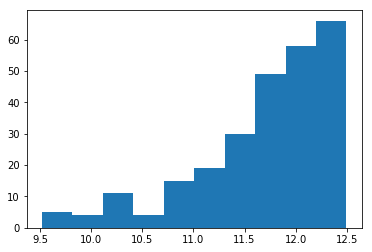

In [31]:
import matplotlib.pyplot as plt 
%matplotlib inline

plt.hist(rb_test_giants['ks0'])